### study2_rubric_train_and_eval_v0.1
- 最終更新: 2023/7/26, 07:50

- 研究2: 採点基準表モデルの学習/評価（研究1の全データ）

#### Google Driveのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 環境構築

aptやらpipやらの下準備
- 参考: https://qiita.com/karaage0703/items/30485c2ba1c396760982

In [2]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7
!pip install fugashi ipadic unidic-lite
!pip install scikit-learn

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcwidget4 libsigc++-2.0-0v5 libxapian30
Suggested packages:
  apt-xapian-index aptitude-doc-en | aptitude-doc debtags tasksel
  libcwidget-dev xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcwidget4 libsigc++-2.0-0v5 libxapian30
0 upgraded, 5 newly installed, 0 to remove and 8 not upgraded.
Need to get 3,838 kB of archives.
After this operation, 17.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 aptitude-common all 0.8.13-3ubuntu1 [1,719 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsigc++-2.0-0v5 amd64 2.10.4-2ubuntu3 [12.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcwidget4 amd64 0.5.18-5build1 [306 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libxapian30 amd64 

In [3]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 10.1 MB/s eta 0:00:00


In [4]:
#transformersの準備
!pip install transformers[torch] neologdn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 25.7 MB/s eta 0:00:00
  Created wheel for neologdn: filename=neologdn-0.5.1-cp310-cp310-linux_x86_64.whl size=182992 sha256=1f397c3b97339252c236f517dc8d5c7aa058618242b7f9545f4c236b2b270e06
  Stored in directory: /root/.cache/pip/wheels/9d/19/20/8db53d94dea31481e7b7a66ca4ed9f6a8e20e349471a2796f2
Successfully built neologdn


In [5]:
pip install accelerate -U

In [6]:
#GPUの認識状況の確認
!nvidia-smi

Tue Jul 25 22:36:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### 以下はコード

##### データの準備
- v0.2までは`data_basic`を使っていた（train/test splitのみ実施）


In [7]:
#ライブラリのインポート
import numpy as np
import pandas as pd
import tqdm

In [8]:
import torch
from torch import nn
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from transformers import AdamW

In [9]:
#乱数のseedを全固定する
#ref: https://qiita.com/ku_a_i/items/bac3befedbadab45774f
import random
import os
RANDOM_STATE = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(RANDOM_STATE)

In [10]:
#採点基準表のデータを読み込む
data_rubric = pd.read_excel('/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/data/CreateSST_PreExp_SST_20230103_1258_ScoringKey_v5.1.xlsx', sheet_name=0, index_col=None)
data_rubric = data_rubric.rename(columns={"point": "labels"})

#入力に使うtextを準備
data_rubric["text"] = data_rubric['word1'] + "[SEP]" + data_rubric["word2"] + "[SEP]" + data_rubric["scoring_key"]
data_rubric

,word_pair,word1,word2,scoring_key,labels,text
0,鳥-飛行機,鳥,飛行機,飛ぶ,2,鳥[SEP]飛行機[SEP]飛ぶ
1,鳥-飛行機,鳥,飛行機,空を飛ぶ,2,鳥[SEP]飛行機[SEP]空を飛ぶ
2,鳥-飛行機,鳥,飛行機,空を飛ぶことができる,2,鳥[SEP]飛行機[SEP]空を飛ぶことができる
3,鳥-飛行機,鳥,飛行機,飛ぶことができる,2,鳥[SEP]飛行機[SEP]飛ぶことができる
4,鳥-飛行機,鳥,飛行機,空中を移動する,2,鳥[SEP]飛行機[SEP]空中を移動する
...,...,...,...,...,...,...
408,美術館-墓,美術館,墓,飾る,1,美術館[SEP]墓[SEP]飾る
409,美術館-墓,美術館,墓,人が集まる,1,美術館[SEP]墓[SEP]人が集まる
410,美術館-墓,美術館,墓,人が訪れる,1,美術館[SEP]墓[SEP]人が訪れる
411,美術館-墓,美術館,墓,石がある,1,美術館[SEP]墓[SEP]石がある


In [11]:
#採点基準表
print(len(data_rubric.word_pair.unique()))
print(data_rubric.word_pair.unique())

20
['鳥-飛行機' '剣-拳銃' 'みかん-ボール' '太陽-電球' '紙-葉っぱ' '山頂-針' '道-川' '愛-薬物' '山-障害物'
 '輪っか-ネックレス' 'なぞなぞ-迷宮' '時間-川' '会社-木' '酒場-教会' '理論-建物' 'ダイヤモンド -雪片' '記憶-牢獄'
 '結婚-合金' '思考-網' '美術館-墓']


#### ネガティブサンプル(labels == 0)の作成
1. 新しいデータフレームをつくる
1. data_rubricのword_pairごとの正例の件数を数える
1. data_rburicから現在のpairを除いたsubsetを作る
1. data_rubricの現在のword_pairをそのまま新しいデータフレームにコピペする
1. subsetからランダムにword_pair件数分をサンプルし、labels = 0とする
  - word_pair, word1, word2, text, labelsをそれぞれ新しく定義してやる必要がある
1. 新しいデータフレームに上記サンプル結果をコピペする

In [12]:
#新しいデータフレームを作る
data_rubric_with_ns = pd.DataFrame(columns=data_rubric.columns)

#正例の件数を数える
data_rubric_ps_count = data_rubric.groupby("word_pair").size()

#word_pairを回す
for cur_word_pair in data_rubric.word_pair.unique():
  #data_rubricの現在のword_pairをそのまま新しいデータフレームにコピペする
  sub_word_pair = data_rubric[data_rubric["word_pair"] == cur_word_pair]
  data_rubric_with_ns = pd.concat([data_rubric_with_ns, sub_word_pair])

  #data_rburicから現在のpairを除いたsubsetを作る
  sub_without_word_pair = data_rubric[data_rubric["word_pair"] != cur_word_pair]

  #subsetからランダムにword_pair件数の半分をサンプルし、labels = 0とする
  cur_negative_samples = sub_without_word_pair.sample(n=data_rubric_ps_count[cur_word_pair] // 2)
  cur_negative_samples["word_pair"] = cur_word_pair
  cur_negative_samples["word1"] = cur_word_pair.split("-")[0]
  cur_negative_samples["word2"] = cur_word_pair.split("-")[1]
  cur_negative_samples["labels"] = 0
  cur_negative_samples["text"] = cur_negative_samples["word1"] + "[SEP]" + cur_negative_samples["word2"] + "[SEP]" + cur_negative_samples["scoring_key"]

  #新しいデータフレームに上記サンプル結果をコピペする
  data_rubric_with_ns = pd.concat([data_rubric_with_ns, cur_negative_samples])

In [13]:
data_rubric_with_ns

,word_pair,word1,word2,scoring_key,labels,text
0,鳥-飛行機,鳥,飛行機,飛ぶ,2,鳥[SEP]飛行機[SEP]飛ぶ
1,鳥-飛行機,鳥,飛行機,空を飛ぶ,2,鳥[SEP]飛行機[SEP]空を飛ぶ
2,鳥-飛行機,鳥,飛行機,空を飛ぶことができる,2,鳥[SEP]飛行機[SEP]空を飛ぶことができる
3,鳥-飛行機,鳥,飛行機,飛ぶことができる,2,鳥[SEP]飛行機[SEP]飛ぶことができる
4,鳥-飛行機,鳥,飛行機,空中を移動する,2,鳥[SEP]飛行機[SEP]空中を移動する
...,...,...,...,...,...,...
248,美術館-墓,美術館,墓,楽しい,0,美術館[SEP]墓[SEP]楽しい
357,美術館-墓,美術館,墓,ネットワーク状,0,美術館[SEP]墓[SEP]ネットワーク状
337,美術館-墓,美術館,墓,2つの要素が一つになる,0,美術館[SEP]墓[SEP]2つの要素が一つになる
46,美術館-墓,美術館,墓,平坦なシート,0,美術館[SEP]墓[SEP]平坦なシート


In [14]:
#インデックスのふりなおし
#ref: https://note.nkmk.me/python-pandas-reset-index/
data_rubric_with_ns_reset_index = data_rubric_with_ns.reset_index()
data_rubric_with_ns_reset_index.head(11)

,index,word_pair,word1,word2,scoring_key,labels,text
0,0,鳥-飛行機,鳥,飛行機,飛ぶ,2,鳥[SEP]飛行機[SEP]飛ぶ
1,1,鳥-飛行機,鳥,飛行機,空を飛ぶ,2,鳥[SEP]飛行機[SEP]空を飛ぶ
2,2,鳥-飛行機,鳥,飛行機,空を飛ぶことができる,2,鳥[SEP]飛行機[SEP]空を飛ぶことができる
3,3,鳥-飛行機,鳥,飛行機,飛ぶことができる,2,鳥[SEP]飛行機[SEP]飛ぶことができる
4,4,鳥-飛行機,鳥,飛行機,空中を移動する,2,鳥[SEP]飛行機[SEP]空中を移動する
5,5,鳥-飛行機,鳥,飛行機,空中を移動することができる,2,鳥[SEP]飛行機[SEP]空中を移動することができる
6,6,鳥-飛行機,鳥,飛行機,どちらも翼がある,1,鳥[SEP]飛行機[SEP]どちらも翼がある
7,7,鳥-飛行機,鳥,飛行機,どちらも羽がある,1,鳥[SEP]飛行機[SEP]どちらも羽がある
8,8,鳥-飛行機,鳥,飛行機,空で見つけられる,1,鳥[SEP]飛行機[SEP]空で見つけられる
9,97,鳥-飛行機,鳥,飛行機,止められない,0,鳥[SEP]飛行機[SEP]止められない


### 訓練データとテストデータの分割→予備調査全件を学習するので不要


In [15]:
#cudaを使う準備
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [16]:
from datasets import Dataset
def create_dataset(data_all):
  """
  dataset（pandasのデータフレーム）をtorchで使えるデータセットにする
  """

  def tokenize_basic(batch):
      return tokenizer(batch["text"], padding=True, truncation=True)

  data_all = data_all.reset_index()
  dataset_all = Dataset.from_pandas(data_all)
  dataset_all_encoded = dataset_all.map(tokenize_basic, batched=True, batch_size=None)

  return dataset_all_encoded, data_all


# メトリクスの定義
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#Trainerの重みを変えるやつ
#imbalanced dataのlossの定義
#ref: https://huggingface.co/docs/transformers/main/main_classes/trainer
#ref: https://dev.classmethod.jp/articles/huggingface-usage-custom-loss-func/
from transformers import TrainingArguments
from transformers import Trainer
from transformers import EarlyStoppingCallback
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        #2023/4/6: debug
        # print("compute_loss: labels, logits", labels, logits)
        # print("compute_loss: outputs: ", outputs)

        # compute custom loss (suppose one has 3 labels with different weights)
        # 訓練データの正例の逆数で重み付け
        loss_fct = nn.CrossEntropyLoss(weight=cur_config["weight_all"])
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        #print()
        # print("loss_fct: ", loss_fct)
        # print("loss: ", loss)

        return (loss, outputs) if return_outputs else loss

def load_bert_model_and_tokenizer():
  """
  BERTのモデルとトークナイザを呼び出す関数
  ※都度初期化して呼び出したいため、ここで呼ぶ
  """

  model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
  model = model.to(device)
  tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

  return model, tokenizer


class load_config:
  """
  cur_fold_idxを引数として、そのfoldにおけるlogging_stepsとweight_allを受け取る
  """
  #初期化
  def __init__(self):
    self.config = dict()

  def create_logging_steps(self):
    self.config["logging_steps"] = len(data_rubric_with_ns_reset_index) // BATCH_SIZE

  def create_weight_all(self):
    """
    weight_allを計算する
    ref: https://dev.classmethod.jp/articles/huggingface-usage-custom-loss-func/
    ref_conc: weight_all = torch.tensor([len(data_basic_unique_train)/75, len(data_basic_unique_train)/528, len(data_basic_unique_train)/494]).clone().to(device, torch.float32)
    """
    self.config["weight_all"] = torch.tensor([len(data_rubric_with_ns_reset_index) /len(data_rubric_with_ns_reset_index),
                                            len(data_rubric_with_ns_reset_index) /len(data_rubric_with_ns_reset_index),
                                            len(data_rubric_with_ns_reset_index) /len(data_rubric_with_ns_reset_index)]).clone().to(device, torch.float32)

  def return_config(self):
    self.create_logging_steps()
    self.create_weight_all()
    return self.config

#結果の評価
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
def plot_confusion_matrix(y_preds, y_true, output_dir):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.savefig(output_dir+"confusion_matrix.png")
    plt.show()

def tokenize_basic(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

#### モデルの訓練と評価

Map:   0%|          | 0/616 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.089000,1.035327,0.462662,0.413669
2,1.032200,0.950708,0.522727,0.440952
3,0.966800,0.851859,0.686688,0.678346
4,0.918100,0.729366,0.735390,0.734464
5,0.810700,0.618411,0.803571,0.801199
6,0.709300,0.513689,0.832792,0.827662
7,0.634200,0.440463,0.862013,0.860282
8,0.586600,0.395695,0.881494,0.880338
9,0.534900,0.354306,0.907468,0.906930
10,0.512500,0.349005,0.915584,0.915212


best model:  /content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study2/study2_rubric_train_and_eval/checkpoint-200


<ipython-input-18-e7905f4f1c0b>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_eval_unique["text"] = data_eval_unique['word1'] + "[SEP]" + data_eval_unique["word2"] + "[SEP]" + data_eval_unique["answer"]


Map:   0%|          | 0/1309 [00:00<?, ? examples/s]

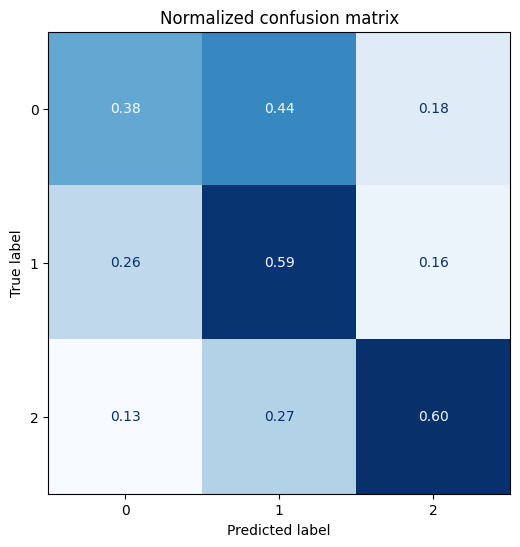

              precision    recall  f1-score   support

           2       0.16      0.38      0.23       120
           1       0.64      0.59      0.61       630
           0       0.74      0.60      0.66       559

    accuracy                           0.57      1309
   macro avg       0.51      0.52      0.50      1309
weighted avg       0.64      0.57      0.60      1309



In [18]:
MODEL_OUTPUT_DIR = "/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study2/study2_rubric_train_and_eval"
MODEL_NAME = "cl-tohoku/bert-base-japanese"
RESULT_OUTPUT_DIR_BASE = "/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/result/study2/study2_rubric_train_and_eval/"
BATCH_SIZE = 32

#config関数から呼び出し
cur_lc = load_config()
cur_config = cur_lc.return_config()

#モデルとトークナイザの初期化
model, tokenizer = load_bert_model_and_tokenizer()

#データセットの用意
dataset_all_encoded, data_all = create_dataset(data_rubric_with_ns_reset_index)

#Trainerのconfig周り
#TrainingArgumentsの準備
#ref: https://dev.classmethod.jp/articles/huggingface-usage-early-stopping/
#ref: https://stackoverflow.com/questions/62525680/save-only-best-weights-with-huggingface-transformers
training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_DIR,
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=0.01,
    save_strategy="epoch",#4/4まで; noにして, どうなるかを確認する->load_best_model_at_endと重複するからnoはダメらしい
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=cur_config["logging_steps"],
    push_to_hub=False,
    log_level="error",
    label_names=['labels'],
    load_best_model_at_end=True,
    save_total_limit=1,
)

# Trainerの定義
trainer = CustomTrainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset_all_encoded,
    eval_dataset=dataset_all_encoded,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# トレーニング実行
trainer.train()

#trainerのbestモデルの場所を書く
print("best model: ", trainer.state.best_model_checkpoint)

#モデルの保存を明示的に書く
trainer.save_model()

#評価する
#評価データの読み込み
data_eval = pd.read_excel('/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/data/20230412_edited_dat_after_aggregate_v0.1.xlsx', sheet_name=0, index_col=None)
#単語1, 単語2, 参加者の回答, 回答に対するlabels(FianlRatingの名前をlabelsとした)
data_eval = data_eval.loc[:, ["word_pair", "answer", "FinalRating"]]
data_eval = pd.concat([data_eval, data_eval['word_pair'].str.split('-', expand=True)], axis=1).drop('word_pair', axis=1)
data_eval = data_eval.rename(columns={0: 'word1', 1: 'word2', "FinalRating": "labels"})
data_eval = data_eval.reindex(columns=["word1", "word2", "answer", "labels"])
data_eval_unique = data_eval.drop_duplicates(subset=['word1', 'word2', 'answer', 'labels'], keep='first')
data_eval_unique["text"] = data_eval_unique['word1'] + "[SEP]" + data_eval_unique["word2"] + "[SEP]" + data_eval_unique["answer"]
data_eval_unique = data_eval_unique.dropna(subset=["word1", "word2"], how="all")
data_eval_unique["labels"] = data_eval_unique["labels"].astype(int)

data_eval_unique_reset_index = data_eval_unique.reset_index()
dataset_eval_unique_reset_index = Dataset.from_pandas(data_eval_unique_reset_index)
dataset_eval_unique_reset_index_encoded = dataset_eval_unique_reset_index.map(tokenize_basic, batched=True, batch_size=None)

preds_output = trainer.predict(dataset_eval_unique_reset_index_encoded)
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(data_eval_unique_reset_index["labels"])
data_eval_unique_reset_index["pred"] = y_preds

#confusion_matrixの表示と保存
plot_confusion_matrix(data_eval_unique_reset_index["pred"], data_eval_unique_reset_index["labels"], RESULT_OUTPUT_DIR_BASE)

#classification_reportの表示と保存
categories = data_eval_unique_reset_index['labels'].unique().tolist()
categories = list(map(str, categories))
classification_report_txt = classification_report(y_valid, y_preds, target_names=categories)
print(classification_report_txt)

with open(RESULT_OUTPUT_DIR_BASE + "classification_report.txt", "w") as output_file:
  output_file.write(classification_report_txt)

data_all.to_csv("/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/result/study2/study2_rubric_train_and_eval/data_train.csv", index=False)
data_eval_unique_reset_index.to_csv("/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/result/study2/study2_rubric_train_and_eval/data_test.csv", index=False)